# Ontario General Election Analysis
---
## Motivation
We wanted to analyze the results of the 2018 Ontario general election. In particular we were interested in the role that financial donations play in predicting success in elections on a per-district level. By examining data sources that were available from Elections Ontario, it seemed that it would be possible to determine relationships between the success of candidates and parties running for election, and the financial donations that they recieved in the lead-up to the election. 

In [1]:
# - Try to combine some old/new districts
# - Density categories
# - Predict 2022

In [2]:
# Topic: Financial contributions and election results in Ontario General Elections

# Data Set: Various combined from Elections Ontario website

# Question: Data about financial contributions and election results obtained from the Elections Ontario website and combined
# in order to determine the effect that financial contributions have towards elections results in the various electoral districts,
# depending on the party that recieves the contributions and other factors.

%matplotlib inline
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import pylab 
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from pandas.core.frame import DataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import requests
import json
import csv
from typing import List


import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)


# First we read the csv files into data frames.


df2014 = pd.read_csv('2014_Filed_Statement_Contributions.csv')
df2015 = pd.read_csv('2015_Filed_Statement_Contributions.csv')
df2016 = pd.read_csv('2016_Filed_Statement_Contributions.csv')
df2017 = pd.read_csv('2017_Filed_Statement_Contributions.csv')
df2018 = pd.read_csv('2018_Filed_Statement_Contributions.csv')
df2019 = pd.read_csv('2019_Filed_Statement_Contributions.csv')
df2020 = pd.read_csv('2020_Filed_Statement_Contributions.csv')
df2021 = pd.read_csv('2021_Filed_Statement_Contributions.csv')

dfresults2011 = pd.read_csv('Explorer_All_15072022_214115.csv')
dfresults2014 = pd.read_csv('Explorer_All_15072022_214028.csv')
dfresults2018 = pd.read_csv('Explorer_All_15072022_192010.csv')


# Here we had to change the abbreviations because they weren't consistent throughout the years


map2011 = {'PC':'PCP','ND':'NDP','L':'LIB','GP':'GPO'}
map2014 = {'OLP':'LIB'}

dfresults2011['Party']=dfresults2011['Party'].replace(map2011)
dfresults2014['Party']=dfresults2014['Party'].replace(map2014)


# Now we combine all the data frames into two larger ones.


dffinance = pd.concat([df2014,df2015,df2016,df2017,df2018])
dfresults = pd.concat([dfresults2011,dfresults2014,dfresults2018])

# Formating Amount, creating a new, consistent District attribute, and creating an attribute that notes if that district/party
# combination won the district.

dffinance['Party']=dffinance['Party Abbreviation']
dffinance['District'] = dffinance['Electoral District'].str[6:].astype(dtype='string').str.replace('—', ' ').str.replace('--', ' ')
dfresults['District'] = dfresults['Electoral District'].str[6:].astype(dtype='string').str.replace('—', ' ').str.replace('--', ' ')
dffinance['Amount'] = dffinance['Amount'].replace('[\$,]', '', regex=True).astype(float)
def wincheck(num):
    if num ==0:
        return 0
    else:
        return 1
dfresults['Winner']= dfresults['Plurality'].map(wincheck)

finance = dffinance[['District','Party','Amount']]
finance = finance.fillna('0')
finance.sort_values(by='District')
finance.groupby(['District']).sum()

results = dfresults[['District','Year','Party','Votes Cast','Winner']]

# Combining everything into one data frame where each row is one district/party combination

mainresults = results.loc[results['Party'].isin(['LIB','PCP','NDP','GPO'])]
mainfinance = finance.loc[finance['Party'].isin(['LIB','PCP','NDP','GPO'])]

mainresults2018 = mainresults.loc[mainresults['Year'] == 2018]
mainresults2014 = mainresults.loc[mainresults['Year'] == 2014]
mainresults2011 = mainresults.loc[mainresults['Year'] == 2011]
mainresults2014 = mainresults2014.rename(columns = {'Votes Cast':'Votes Cast 2014','Winner':'Winner 2014'})
mainresults2011 = mainresults2011.rename(columns = {'Votes Cast':'Votes Cast 2011','Winner':'Winner 2011'})

groupresults=mainresults2018.groupby(['District','Party']).sum()

groupedyears = pd.merge(mainresults2014,mainresults2011,on=['District','Party'], how = 'outer')

groupfinance=mainfinance.groupby(['District','Party']).sum()

complete=pd.merge(groupresults,groupfinance,on=['District','Party'], how = 'inner')

complete = pd.merge(complete,groupedyears,on=['District','Party']).drop(columns=['Year','Year_x','Year_y'])


# Adding a Vote % attribute, indicating what percentage of the total votes wen to that party, and an attribute for if the entry
# won the 2022 election - full data was not available for 2022 but it will be used later.


complete['Vote %'] = complete['Votes Cast']/complete.groupby('District')['Votes Cast'].transform('sum')

dfwinners2022 = pd.read_csv('Winning parties 2022.csv')
winners2022map = {'Progressive Conservative':'PCP','New Democratic':'NDP','Liberal':'LIB','Green':'GPO'}
dfwinners2022['Party']=dfwinners2022['Party'].replace(winners2022map)
dfwinners2022['District'] = dfwinners2022['District'].str.replace('—', ' ').str.replace('--', ' ')
dfwinners2022['Winner 2022']=1

complete = pd.merge(complete,dfwinners2022, left_on = ['District','Party'], right_on = ['District','Party'], how = 'outer').dropna(subset = ['Votes Cast']).fillna(0)


# Created a new data frame for the entire party and their financial contributions, and renamed attributes so there is now
# a District Donation attribute corresponding to the donations recieved by the candidate in that district, as well as a 
# Total Party Donation attribute corresponding to the total donations received by the party in the entire province.


completegroups = complete.groupby('Party').sum()

for party in ['GPO','LIB','NDP','PCP']:
    
    completegroups.loc[party,'Amount'] = finance.groupby('Party').sum().loc[party,'Amount']

complete['Total Party Donations'] = complete['Party'].map(dict(completegroups['Amount']))

complete = complete.rename(columns={'Amount':'District Donations'})
completegroups = completegroups.rename(columns={'Amount':'Total Party Donations'})

complete['District Donations'] = complete['District Donations'].fillna(0)

# Created attributes based on the population, area, and population density of each electoral district, as well as an attribute 
# Voter Turnout that is the percentage of the population that voted.

dfpoparea = pd.read_csv('population area.csv')
dfpoparea['District'] = dfpoparea['District'].astype('string').str.zfill(3)
nums = dfresults['Electoral District'].str.extract(r'([0-9]{3,})')
words = dfresults['Electoral District'].str[6:].astype(dtype='string').str.replace('—', ' ').str.replace('--', ' ')
dictdistrict = dict(zip(nums[0],words))
dfpoparea['District'] = dfpoparea['District'].map(dictdistrict)

complete['District'] = complete['District'].astype('string')
complete['Area'] = complete['District'].map(dict(dfpoparea[['District', 'Area']].values)).str.replace(',','').astype('int32')
complete['Population'] = complete['District'].map(dict(dfpoparea[['District', 'Population']].values)).str.replace(',','').astype('int32')
complete['Density'] = complete['Population']/complete['Area']
complete['Voter Turnout'] = complete['District'].map(dict(complete.groupby('District').sum()['Votes Cast']))/complete['Population']


# Created a new data frame that is able to compare the donations made by each party in each of the districts.


gpodonations = complete.loc[complete['Party']=='GPO'][['District','District Donations']].rename(columns = {'District Donations':'GPO Donations'})
libdonations = complete.loc[complete['Party']=='LIB'][['District','District Donations']].rename(columns = {'District Donations':'LIB Donations'})
ndpdonations = complete.loc[complete['Party']=='NDP'][['District','District Donations']].rename(columns = {'District Donations':'NDP Donations'})
pcpdonations = complete.loc[complete['Party']=='PCP'][['District','District Donations']].rename(columns = {'District Donations':'PCP Donations'})

partydonations = gpodonations.merge(libdonations, how = 'outer', on = 'District').merge(ndpdonations, how = 'outer', on = 'District').merge(pcpdonations, how = 'outer', on = 'District')

# The palette below is made for the graphs.

partypalette = {'LIB':'red', 'PCP':'blue', 'GPO':'green', 'NDP':'orange'}

##############################################################################################################
# Finally we have useful data frames we can do some analysis with.
##############################################################################################################

---
## Gathering Data
The data that we were interested in analyzing were data related to the results of the 2018 Ontario general election. We were especially interested in finding data related to the financial contributions towards the political parties involved in the election and to the candidates running in different electoral districts. We were also interested in other data related to the electoral districts. The data for the financial contributions from the years 2014-2018 were used, because those were the years leading up to the 2018 election, and seemed the most applicable donations towards that particular election. The financial contribution data was downloaded from the Elections Ontario website in the form of a .csv file[^1]. The results of the general elections in 2011, 2014 and 2018, were similarly retrieved from the Elections Ontario website[^2]. Data for the population and area were scraped from the Elections Ontario website[^3] since it was not available for download and the information on the page for each district needed to be combined. The results for the 2022 election were not available, and were instead retrieved from Wikipedia[^4].
<span style="font-family:Papyrus; font-size:0.5em;">
[^1]: Elections Ontario. (n.d.). Retrieved August 14, 2022, from https://results.elections.on.ca/en/data-explorer?fromYear=1867&amp;toYear=2022&amp;electionId=504&amp;levelOfDetail=candidate  
[^2]: Elections Ontario. (n.d.). Retrieved August 14, 2022, from https://finances.elections.on.ca/en/contributions?fromYear=2014&amp;toYear=2022 
[^3]: Elections Ontario. (n.d.). Retrieved August 14, 2022, from https://voterinformationservice.elections.on.ca/en/electoral-district/1 
[^4]: Wikimedia Foundation. (2022, July 27). 2022 Ontario general election. Wikipedia. Retrieved August 14, 2022, from https://en.wikipedia.org/wiki/2022_Ontario_general_election </span>

---
## Challenges Preparing Data
One significant difficulty that occured was due to the change of the Ontario electoral districts in 2018. The 107 districts that existed in the 2011 and 2014 elections were increased by 17 to 124, and many of the districts had their boundaries redrawn. This presented a significant hurdle since donations to many districts in the years leading up to the election could not be mapped directly onto the districts that existed during the election. It was decided to only use the districts that did not change, which still represented a significant sample.
Another issue is that many of the donation entries were not to a particular candidate in an electoral district, and were instead to the provincial party. Since these donations represented a majority of the money donated during the 2014-2018 period examined, they needed to be accounted for, and that was done by including a variable for each candidate that corresponded to the total financial donations of their party.
lastly, the existence of a large number of political parties that won no ridings, and received very little or no financial donations threatened to make the analysis unecessarily messy, so the decision was made to only include parties that won at least one riding, so the Liberal, Progressive Conservative, Green, and New Democratic parties were the only ones used.
Below we can see the distribution of votes recieved vs financial donations recieved, for each candidate. We can also see the votes recieved and the financial donations recieved for each party, side-by-side.

<div style="page-break-after: always;"></div>


In [74]:
# completegroups.head(5)

In [4]:
# partydonations.head(5)

In [5]:
# complete.head(5)

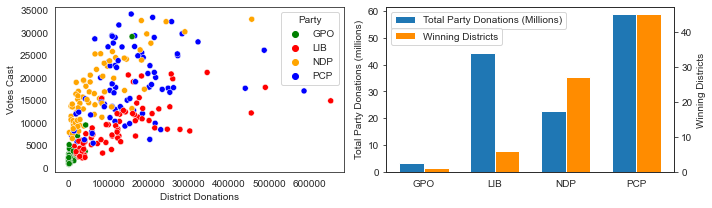

In [75]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax2 = ax[1].twinx()

sns.set_style("white")

# sns.jointplot(data = complete, x = 'District Donations', y = 'Votes Cast', hue = 'Party', palette = partypalette, height = 4, ax= ax[0])
# sns.relplot(data = complete, x = 'Total Party Donations', y = "Votes Cast", hue = "Party", palette = partypalette, size = "Winner", sizes=(40, 400), alpha=.5, height=4, ax = ax[1])
sns.scatterplot(data = complete, x = 'District Donations', y = 'Votes Cast', hue = 'Party', palette = partypalette, ax= ax[0])
# sns.barplot(data = completegroups.reset_index(), x = 'Party', y = "Votes Cast",  ax = ax[1], color = 'grey', alpha = 0.8)

# sns.scatterplot(data = completegroups.reset_index(), x = 'Party', y = "Total Party Donations", hue = 'Party', s = 200,  ax = ax3, palette = partypalette)

labels = list(completegroups.index)
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

ax[1].set_xticks(x, labels)

ax[1].bar(x - width/2, completegroups['Total Party Donations']/1000000, width, label='Total Party Donations (Millions)')
ax2.bar(x + width/2, completegroups['Winner'], width, label='Winning Districts', color = 'darkorange')

ax[1].set_ylabel('Total Party Donations (millions)')

ax2.set_ylabel('Winning Districts')

ax[1].legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax[1].transAxes)
ax2.legend(loc="upper left", bbox_to_anchor=(0,0.9), bbox_transform=ax[1].transAxes)

# plt.title('Votes Cast vs District Donations')
# plt.tight_layout()
# plt.savefig('votes and district donations.png')
fig.tight_layout()
fig.show()

In [7]:
##############################################################################################################################
##############################################################################################################################

---
## Conclusions
There does appear to be a relationship between donations and election outcomes. The parties that recieved a larger total amount of financial donations tended to win more seats in an election, and also the candidates that recieve more donations were more likely to win their riding. A linear regression to predict the number of votes that a candidate will recieve, based on the donations they recieve, accounts for slightly more than a third of the variation in the number of votes recieved. Similarly, in an effective machine learning model that predicts winning candidates with approximately 90% accuracy, the most important feature is the donations that the candidate recieved. 